In [1]:
#imports
import torch
import numpy as np
import random
PATH = './patch_pair_net.pth'


In [2]:
# constants
PATCH_SIZE = 28


In [3]:
# see if we have a gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# function to show an image
def show_image(image: np.ndarray):
	plt.imshow(image, vmin=0, vmax=255)
	plt.axis("off")
	plt.show()


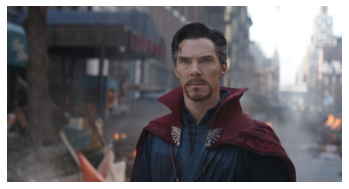

In [5]:
import cv2

# load a test image and show it
test_image_path = "./TestImages/Strange.png"
test_image = cv2.imread(test_image_path)
test_image = np.fliplr(test_image.reshape(-1,3)).reshape(test_image.shape)

show_image(test_image)


In [6]:
# enum-like values to indicate how far the patch has been rotated counter clockwise
ROTATION_0 = 0
ROTATION_90 = 1
ROTATION_180 = 2
ROTATION_270 = 3

NOT_A_PAIR = 16

def combination_index_from_rotations(rotation1: int, rotation2: int) -> int:
	return ((4 * rotation1) + rotation2) % 16

def rotations_from_combination_index(combination_index: int) -> (int, int):
	if combination_index >= 16 or combination_index < 0:
		return None, None
	rotation1 = combination_index // 4
	rotation2 = combination_index % 4
	return rotation1, rotation2

def show_combined_patches(data1: np.ndarray, data2: np.ndarray, combination_index):
	r1, r2 = rotations_from_combination_index(combination_index)
	if r1 is None or r2 is None:
		print("invalid combination index; cannot be combined")
		return
	combined = np.empty((data1.shape[0], data1.shape[1] + data2.shape[1], data1.shape[2]), dtype=data1.dtype)
	combined[:, :data1.shape[1]] = np.rot90(data1, (4 - r1) % 4)
	combined[:, data1.shape[1]:] = np.rot90(data2, (4 - r2) % 4)
	show_image(combined)

class Patch:
	def __init__(self, data: np.ndarray, row: int, col: int):
		self.data = data
		self.row = row
		self.col = col

	def random_rotation(self):
		rotation_index = random.randrange(4)
		new_data = np.rot90(self.data, rotation_index)
		return Patch(new_data, self.row, self.col), rotation_index

	def show(self):
		print("row =", self.row, "| col =", self.col)
		show_image(self.data)

def random_patch(image: np.ndarray, h: int, w: int) -> Patch:
	# pick a corner location
	row = random.randrange(image.shape[0] - h)
	col = random.randrange(image.shape[1] - w)
	# make the patch
	return Patch(image[row:row+h, col:col+w], row, col)

BUFFER_SIZE = 7

def make_pairs_of_patches(image: np.ndarray, total_pairs: int = 8, number_of_good: int = None) -> list:
	if number_of_good is None:
		number_of_good = random.randrange(total_pairs + 1)
	number_of_bad = total_pairs - number_of_good
	h = image.shape[0]
	w = image.shape[1]
	if h < PATCH_SIZE or w < PATCH_SIZE:
		print("cannot make patches from this image (%dx%d); minimum dimensions are %dx%d" %
		      (h, w, PATCH_SIZE, PATCH_SIZE))
		return list()
	# pick doubly long squares, chop them in half
	good_pairs = list()
	while len(good_pairs) < number_of_good:
		if bool(random.randrange(2)):  # pick vertical or horizontal
			# horizontal
			pair_patch = random_patch(image, PATCH_SIZE, 2 * PATCH_SIZE)
		else:
			# vertical
			pair_patch = random_patch(image, 2 * PATCH_SIZE, PATCH_SIZE)
			pair_patch.data = np.rot90(pair_patch.data)
		patch1 = Patch(pair_patch.data[:, :PATCH_SIZE, :], pair_patch.row, pair_patch.col)
		patch2 = Patch(pair_patch.data[:, PATCH_SIZE:, :], pair_patch.row, pair_patch.col + PATCH_SIZE)
		patch1, patch1_rotation = patch1.random_rotation()
		patch2, patch2_rotation = patch2.random_rotation()
		combination_index = combination_index_from_rotations(patch1_rotation, patch2_rotation)
		good_pairs.append(((patch1.data, patch2.data), combination_index))
	# pick random patches and make sure they don't actually line up
	bad_pairs = list()
	while len(bad_pairs) < number_of_bad:
		patch1 = random_patch(image, PATCH_SIZE, PATCH_SIZE)
		patch2 = random_patch(image, PATCH_SIZE, PATCH_SIZE)
		r_gap = abs(patch1.row - patch2.row) - PATCH_SIZE
		c_gap = abs(patch1.col - patch2.col) - PATCH_SIZE
		if r_gap + c_gap > BUFFER_SIZE:
			patch1 = patch1.random_rotation()[0]
			patch2 = patch2.random_rotation()[0]
			bad_pairs.append(((patch1.data, patch2.data), NOT_A_PAIR))
	all_pairs = good_pairs + bad_pairs
	random.shuffle(all_pairs)
	return all_pairs

test_pairs = make_pairs_of_patches(test_image, 20, 10)


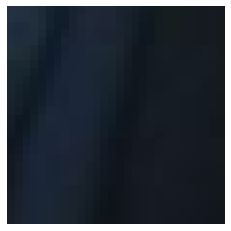

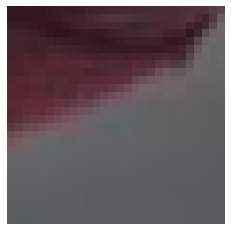

combo_index: 16
invalid combination index; cannot be combined


In [7]:
# preview some data
index_to_show = random.randrange(len(test_pairs))
(pic1, pic2), combo_index = test_pairs[index_to_show]
show_image(pic1)
show_image(pic2)
print("combo_index:", combo_index)
show_combined_patches(pic1, pic2, combo_index)


In [8]:
import torchvision
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

# get a bunch of images to use for training data
transform = transforms.ToTensor()
train_data = torchvision.datasets.STL10(root='./data', split="unlabeled", download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=4, shuffle=True, num_workers=2)
test_data = torchvision.datasets.STL10(root='./data', split="test", download=True, transform=transform)
test_loader = DataLoader(test_data, batch_size=4, shuffle=False, num_workers=2)


KeyboardInterrupt: 

In [ ]:
# convert our data

def patch_pair_to_tensor(patch1, patch2):
	patch1 = torch.tensor(np.transpose(patch1.copy(), (2, 0, 1)), dtype=torch.float)
	patch2 = torch.tensor(np.transpose(patch2.copy(), (2, 0, 1)), dtype=torch.float)
	return torch.cat((patch1, patch2), 2)

def batch_to_images(batch):
	# toss the labels
	batch_tensor = batch[0]
	np_images = [np.array(batch_tensor[x, :, :, :]) for x in range(batch_tensor.shape[0])]
	return [np.transpose(im, (1, 2, 0)) for im in np_images]

def index_to_hot(i: int, size: int):
	a = torch.zeros(size)
	a[i] = 0.0
	return a

def convert_loader(given_loader: DataLoader) -> list:
	input_target_pairs = list()
	for b in given_loader:
		images = batch_to_images(b)
		inputs = list()
		targets = list()
		for image in images:
			pairs = make_pairs_of_patches(image)
			for patch_pair, num in pairs:
				pair_tensor = patch_pair_to_tensor(patch_pair[0], patch_pair[1])
				inputs.append(pair_tensor)
				# targets.append(index_to_hot(num, 17))
				targets.append(num)
		new_inputs = torch.stack(inputs)
		new_targets = torch.tensor(targets)
		input_target_pairs.append((new_inputs, new_targets))
	return input_target_pairs

train_formatted_batches = convert_loader(train_loader)
print(len(train_formatted_batches))
test_formatted_batches = convert_loader(test_loader)
print(len(test_formatted_batches))


In [ ]:
import torch.nn as nn
import torch.nn.functional as f

# make a network class

class PatchPairNet(nn.Module):
	def __init__(self):
		super(PatchPairNet, self).__init__()
		self.kernel_size = 3
		self.conv1 = nn.Conv2d(3, 6, self.kernel_size)
		self.pool = nn.MaxPool2d(2, 2)
		self.conv2 = nn.Conv2d(6, 16, self.kernel_size)
		self.fc1 = nn.Linear(16 * 5 * 5 * 2, 120)
		self.fc2 = nn.Linear(120, 84)
		self.fc3 = nn.Linear(84, 17)

	def forward(self, image_pair):
		# first dimension is how many things are in the mini-batch
		# second dimension is channels
		x = image_pair[:, :, :, :PATCH_SIZE]
		y = image_pair[:, :, :, PATCH_SIZE:]
		# put both images through the same convolutions
		x = self.pool(f.relu(self.conv1(x)))
		x = self.pool(f.relu(self.conv2(x)))
		x = x.view(-1, 16 * 5 * 5)
		y = self.pool(f.relu(self.conv1(y)))
		y = self.pool(f.relu(self.conv2(y)))
		y = y.view(-1, 16 * 5 * 5)

		xy = torch.cat((x, y), 1)

		xy = f.relu(self.fc1(xy))
		xy = f.relu(self.fc2(xy))
		xy = self.fc3(xy)
		return xy


net = PatchPairNet()


In [ ]:
# put a pair of images through the net to make sure forward() works

test_combo = patch_pair_to_tensor(pic1, pic2)
test_combo = test_combo[None, :, :, :]
out = net(test_combo)
print(out.shape)
print(torch.argmax(out).item())


In [ ]:
# loss function and optimizer
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.005)  # , momentum=0.5


In [ ]:
import time

SHUFFLE_EVERY_EPOCH = True
SAVE_EVERY_EPOCH = True

# train the network

net.to(device)
for epoch in range(50):  # loop over the dataset multiple times
	if SHUFFLE_EVERY_EPOCH:
		# re-shuffle the data
		print("shuffling data...")
		time_start = time.time()
		train_loader = DataLoader(train_data, batch_size=4, shuffle=True, num_workers=2)
		train_formatted_batches = convert_loader(train_loader)
		time_end = time.time()
		print(f"shuffled data in {time_end - time_start} seconds")

	print("starting epoch", epoch + 1)
	running_loss = 0.0
	time_start = time.time()
	for i, data in enumerate(train_formatted_batches):
		# get the inputs; data is a list of [inputs, labels]
		inputs, labels = data[0].to(device), data[1].to(device)

		# zero the parameter gradients
		optimizer.zero_grad()

		# forward + backward + optimize
		outputs = net(inputs)
		loss = criterion(outputs, labels.long())
		loss.backward()
		optimizer.step()

		# print statistics
		running_loss += loss.item()
		if i % 2000 == 1999:	# print every 2000 mini-batches
			print('[%d, %5d] loss: %.3f' %
				  (epoch + 1, i + 1, running_loss / 2000))
			running_loss = 0.0
	time_end = time.time()
	if SAVE_EVERY_EPOCH:
		torch.save(net.state_dict(), PATH)
	print(f"epoch trained in {time_end - time_start} seconds")

print('Finished Training')


In [ ]:
# save net state
torch.save(net.state_dict(), PATH)


In [ ]:
# re-load the saved state

net = PatchPairNet()
net.load_state_dict(torch.load(PATH))
net.to(device)


In [ ]:
# test the overall accuracy

correct = 0
total = 0
with torch.no_grad():
	for data in test_formatted_batches:
		images, labels = data[0].to(device), data[1].to(device)
		outputs = net(images)
		_, predicted = torch.max(outputs.data, 1)
		total += labels.size(0)
		correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
	100 * correct / total))
